# LAB: Stochastic Gradient Descent SOLUTIONS

The objective of this lab session is to implement:
- Stochastic gradient descent with constant stepsizes
- Stochastic gradient descent with shrinking stepsizes
- Stochastic gradient descent with sampling with/without replacement
- Stochastic gradient descent with averaging 
- Stochastic gradient descent with momentum 

and compare your implementation with gradient descent.

Throughout the notebook you will find commented boxes like this one:

In [0]:
### TODO ###   
# please implement blabla
#############

These boxes need to be replaced by code as explained in the boxes.
Solutions will online tomorrow. Good luck!

In [0]:
%matplotlib inline

In [0]:
import numpy as np
from numpy import linalg as la
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit, jit, jitclass  # A just in time compiler to speed things up!

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top w, b_i) + \frac \lambda 2 \|w\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(w)
$$
where
$$
f_i(w) = \ell(x_i^\top w, y_i) + \frac \lambda 2 \|w\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(w) = (x_i^\top w - y_i) x_i + \lambda w
$$
and
$$
\nabla f_i(w) = - \frac{y_i}{1 + \exp(y_i x_i^\top w)} x_i + \lambda w.
$$

Denote by $L$ the Lipschitz constant of $f$ and $X = [x_1, \ldots, x_n].$
One can see easily that for linear regression
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{n} + \lambda 
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{4 n} + \lambda 
$$
For full-gradient methods, the theoretical step-size is $1 / L$.

We now introduce a class that will be used for the solvers.

In [0]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda  
      
    def grad(self, w):
        ### TODO ###   
        # calculate the gradient of f
        #############
        result = (1/n) * (self.X @ w - self.y) @ self.X + self.lbda*w
        return result
    
    def f_i(self, i, w):
        return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.      
    
    def f(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
# (1/n)X_i (X_i^Tw-y_i) + lbda*w    
    def grad_i(self, i, w):
        ### TODO ###   
        # calculate the gradient of f_i
        #############
        result = (self.X[i].dot(w) - self.y[i])*(self.X[i]) + self.lbda*w
        return result

    def lipschitz_constant(self):
        """Return the smoothness constant (Lipschitz constant of the gradient)"""
        L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        return L
    
    def L_max_constant(self):
        """Return the L_max constant """
        L_max = np.max(np.sum(self.X ** 2, axis=1)) + self.lbda
        return L_max 
    
    def mu_constant(self):
        """Return the strong convexity constant"""
        mu =  min(abs(la.eigvals(np.dot(self.X.T,self.X)))) / self.n + self.lbda
        return mu     

In [0]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
 
    def grad(self, w):
        ### TODO ###   
        # calculate the gradient of f
        #############
        result = (-1/n) * (self.y / (1 + np.exp(self.y * (self.X @ w)))) @ self.X + self.lbda*w
        return result

    def f_i(self,i, w):
        bAx_i = self.y[i] * np.dot(self.X[i], w)
        return np.log(1. + np.exp(- bAx_i)) + self.lbda * norm(w) ** 2 / 2.
    
    def f(self, w):
        bAx = self.y * self.X.dot(w)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(w) ** 2 / 2.
  
    def grad_i(self, i, w):
        ### TODO ###   
        # calculate the gradient of f_i
        #############
        result = (-self.y[i]/(1+np.exp(self.y[i]*(self.X[i].T.dot(w)))))*self.X[i] + self.lbda*w
        return result

    def lipschitz_constant(self):
        """Return the smoothness constant (Lipschitz constant of the gradient)"""
        L = norm(self.X, ord=2) ** 2  / (4. * self.n) + self.lbda
        return L
    def L_max_constant(self):
        """Return the L_max constant """
        L_max = np.max(np.sum(self.X ** 2, axis=1))/4 + self.lbda
        return L_max 
    
    def mu_constant(self):
        """Return the strong convexity constant"""
        mu =  self.lbda
        return mu    

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [0]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

    
def simu_linreg(w, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

In [0]:
def simu_logreg(w, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    X, y = simu_linreg(w, n, std=1., corr=0.5)
    return X, np.sign(y)

### Generate Data

In [0]:
d = 50
n = 1000
idx = np.arange(d)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

#X, y = simu_linreg(w_model_truth, n, std=1., corr=0.1)
X, y = simu_logreg(w_model_truth, n, std=1., corr=0.7)

In [0]:
### Choice of the model

In [0]:
lbda = 1. / n ** (0.5)
#model = LinReg(X, y, lbda)
model = LogReg(X, y, lbda)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


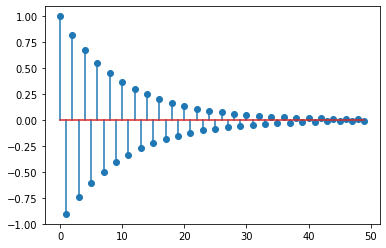

In [61]:
plt.stem(w_model_truth); 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':


2.1130236570995972e-07


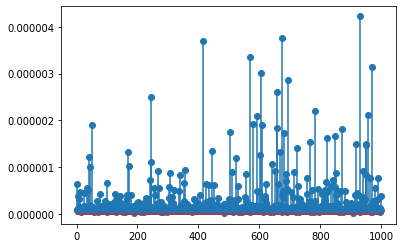

In [100]:
# Check that the gradient grad_i and the numerical gradient of f_i agree
grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    model.f_i(ind[0],w)
    grad_error.append((model.f_i( ind[0], w+eps*vec) - model.f_i( ind[0], w))/eps - np.dot(model.grad_i(ind[0],w),vec))
plt.stem(grad_error); 
print(np.mean(grad_error))

In [101]:
from scipy.optimize import check_grad
modellog = LogReg(X, y, lbda)
# Check that the gradient and the loss numerically match
check_grad(modellog.f, modellog.grad, np.random.randn(d))

1.3525988189812732e-07

In [102]:
modellin = LinReg(X, y, lbda)
# Check that the gradient and the loss numerically match
check_grad(modellin.f, modellin.grad, np.random.randn(d))

1.598860971189032e-06

### Find a highly accurate solution using LBFGS method

In [103]:
from scipy.optimize import fmin_l_bfgs_b

w_init = np.zeros(d)
w_min, obj_min, _ = fmin_l_bfgs_b(model.f, w_init, model.grad, args=(), pgtol=1e-30, factr =1e-30)

print(obj_min)
print(norm(model.grad(w_min)))

0.49464185673917715
1.7508143366908995e-09


<a id='constant'></a> 

## 3. Implementing Stochastic Gradient Descent


### SGD

We recall that an iteration of SGD writes



**for** $t = 1, \ldots, T$ 
  
$\qquad$ Pick $i$ uniformly at random in $\{1, \ldots, n\}$
   
$\qquad \displaystyle
w^{t+1} \gets w^t - \gamma^t \nabla f_i(w^t)
$
  
**end for**



Complete the code below. The inputs are
- n_iter: The number of iterations
- indices: an np.array of indices of length n_iter. The indices[t]  is the index of stochastic gradient that will be used on the t-th iteration. 
- steps: an np.array of positive floats of length n_iter. The steps[t] is the stepsize used on the kth iteration. Typically decreasing stepsizes are used.

- averaging_on: is a boolean which indicates if the output should be the average of the iterates.

The outputs are:
- w_output: The final x vector found by the algorithm or the average  $ \bar{w} = \frac{1}{T-t}\sum_{i=t}^T w^t$ if averaging is on
- objectives: A ndarray containing the sequence function values calculated during the iterations of the algorithm 
- errors: If w_min is not empty, errors is a ndarray containing the sequence of errors || w^t - w_min || of the algorithm. Otherwise errors should be empty.
*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [0]:
def sgd(w0, model, indices, steps, w_min, n_iter=100, averaging_on=False, momentum =0, verbose=True, start_averaging = 0):
    """Stochastic gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # average x
    w_average = w0.copy()
    # estimation error history
    errors = []
    err = 1.0
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w) 
    objectives.append(obj)
    if verbose:
        print("Lauching SGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for t in range(n_iter):
        ### TODO ###   
        ####################################
        # Compute the next iterate
        #  w[:] =........
        ####################################
        w = w - steps[t]*model.grad_i(indices[t],w)
        ####################################
        # Compute the average iterate 
        # w_average[:]  = ...w_average + .....
        ####################################
        if averaging_on:
          if t == start_late_averaging:
            w_average = w
          if(t >= start_averaging):
            w_average = (t-start_averaging+1)/((t+1)-start_averaging+1) * w_average + (w/((t+1)-start_averaging+1))
            w_test = w_average.copy()
          else:
            w_test = w.copy()
        else:
            w_test = w.copy()
        obj = model.f(w_test) 
        if np.any(w_min):
            err = norm(w_test - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if t % n_samples == 0 and verbose:
            if(sum(w_min)):
                print(' | '.join([("%d" % t).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
            else:
                print(' | '.join([("%d" % t).rjust(8), 
                              ("%.2e" % obj).rjust(8)]))
    if averaging_on:
        w_output = w_average.copy()
    else:
        w_output = w.copy()    
    return w_output, np.array(objectives), np.array(errors)

In [0]:
##Setup number of iterations
datapasses = 30  # number of sweeps through all the data. This means that there will datapasses*n stochastic gradient updates
n_iter = int(datapasses * n)

### SGD with constant step with replacement

Implement constant stepsizes with steps[t] $= 1/(2L_{\max})$

In [0]:
Lmax = model.L_max_constant(); # Need this constant

In [200]:
##############TODO######################
# Execute SGD with a constant stepsize. Please name the output as
# w_sgdcr, obj_sgdcr, err_sgdcr = sgd(...?....)
##############END TODO######################
w0 = np.random.rand(model.d)
indices = np.random.randint(model.n,size=n_iter)
steps = np.ones(n_iter)*(1/(2*Lmax))
w_sgdcr, obj_sgdcr, err_sgdcr = sgd(w0,model,indices,steps,w_min,n_iter)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 3.03e+00 | 2.36e+00
    1000 | 5.38e-01 | 3.54e-01
    2000 | 5.26e-01 | 2.52e-01
    3000 | 5.30e-01 | 3.00e-01
    4000 | 5.30e-01 | 2.75e-01
    5000 | 5.24e-01 | 2.70e-01
    6000 | 5.29e-01 | 2.95e-01
    7000 | 5.35e-01 | 2.97e-01
    8000 | 5.37e-01 | 2.76e-01
    9000 | 5.27e-01 | 2.76e-01
   10000 | 5.23e-01 | 2.54e-01
   11000 | 5.42e-01 | 3.25e-01
   12000 | 5.39e-01 | 3.13e-01
   13000 | 5.24e-01 | 2.75e-01
   14000 | 5.46e-01 | 3.36e-01
   15000 | 5.28e-01 | 2.92e-01
   16000 | 5.22e-01 | 2.56e-01
   17000 | 5.25e-01 | 2.73e-01
   18000 | 5.19e-01 | 2.70e-01
   19000 | 5.17e-01 | 2.48e-01
   20000 | 5.43e-01 | 2.88e-01
   21000 | 5.36e-01 | 3.02e-01
   22000 | 5.33e-01 | 3.16e-01
   23000 | 5.21e-01 | 2.57e-01
   24000 | 5.28e-01 | 2.92e-01
   25000 | 5.30e-01 | 2.72e-01
   26000 | 5.32e-01 | 2.64e-01
   27000 | 5.22e-01 | 2.89e-01
   28000 | 5.20e-01 | 2.80e-01
   29000 | 5.34e-01 | 2.89e-01


### SGD with $C/\sqrt{t+1}$ stepsizes with replacement

Try the following decreasing stepsizes steps[t] $= 2/(L_{\max}\sqrt{t+1})$

In [201]:
#############TODO#######################
# Execute SGD with a shrinking stepsize steps[t] = 1/(2L_{\max}(t+1)). Please name the output as
# w_sgdsr, obj_sgdsr, err_sgdsr = sgd(.....?.....)
##############END TODO######################
C = 2 / Lmax
steps = C / np.sqrt(np.array(range(n_iter))+1)
w_sgdsr, obj_sgdsr, err_sgdsr = sgd(w0,model,indices,steps,w_min,n_iter)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 3.02e+00 | 2.36e+00
    1000 | 8.28e-01 | 9.52e-01
    2000 | 6.23e-01 | 7.36e-01
    3000 | 5.77e-01 | 6.23e-01
    4000 | 5.56e-01 | 5.51e-01
    5000 | 5.42e-01 | 4.93e-01
    6000 | 5.32e-01 | 4.48e-01
    7000 | 5.26e-01 | 4.11e-01
    8000 | 5.21e-01 | 3.77e-01
    9000 | 5.17e-01 | 3.53e-01
   10000 | 5.14e-01 | 3.27e-01
   11000 | 5.12e-01 | 3.08e-01
   12000 | 5.09e-01 | 2.89e-01
   13000 | 5.07e-01 | 2.70e-01
   14000 | 5.06e-01 | 2.56e-01
   15000 | 5.05e-01 | 2.43e-01
   16000 | 5.04e-01 | 2.29e-01
   17000 | 5.03e-01 | 2.21e-01
   18000 | 5.02e-01 | 2.11e-01
   19000 | 5.01e-01 | 2.00e-01
   20000 | 5.01e-01 | 1.93e-01
   21000 | 5.01e-01 | 1.87e-01
   22000 | 5.00e-01 | 1.79e-01
   23000 | 5.00e-01 | 1.74e-01
   24000 | 5.00e-01 | 1.68e-01
   25000 | 4.99e-01 | 1.62e-01
   26000 | 4.99e-01 | 1.56e-01
   27000 | 4.99e-01 | 1.50e-01
   28000 | 4.98e-01 | 1.44e-01
   29000 | 4.98e-01 | 1.38e-01


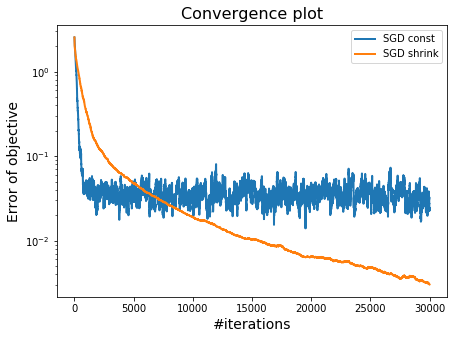

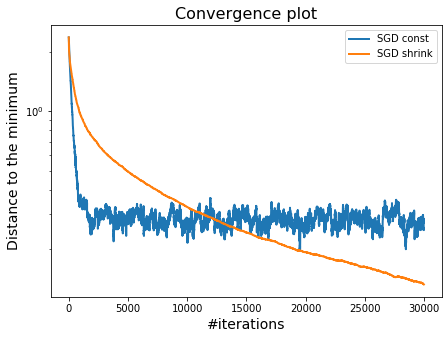

In [202]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdsr - obj_min, label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr , label="SGD const", lw=2)
plt.semilogy(err_sgdsr , label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

**Questions**

- Compare the solution you obtain for SGD with constant stepsizes and SGD with shrinking stepsizes. 
- Which one is faster in the beginning? Which reaches the "best" solution?
- What happens when is you use sampling without replacement instead? Hint: Do only one datapass, it's annoying to adapt this implementation for more than one datapass when sampling without replacement



### SGD with switch to  shrinking stepsizes

In [0]:
mu = model.mu_constant();
Kappa = Lmax/mu;
tstar = 4*int(np.ceil(Kappa));

Test SGD with the following switching stepsizes given in the lecture

$\gamma^t= 
\begin{cases}
\displaystyle \tfrac{1}{2L_{\max}} & \mbox{for}\quad t \leq 4\lceil\mathcal{K} \rceil \\[0.3cm]
\displaystyle \tfrac{2t+1}{(t+1)^2 \mu} &  \mbox{for}\quad t > 4\lceil\mathcal{K} \rceil.
\end{cases}$

In [204]:
#############TODO#######################
# Execute SGD with a switching stepsizes. Please name the output as
# w_sgdsr, obj_sgdss, err_sgdss = sgd(.....?.....)
##############END TODO######################
steps = []
for i in range(n_iter):
  if i <= tstar:
    steps.append(1/(2*Lmax))
  else:
    steps.append((2*(i+1))/(((i+1)**2)*mu))

w_sgdss, obj_sgdss, err_sgdss = sgd(w0,model,indices,steps,w_min,n_iter)


Lauching SGD solver...
   it    |   obj    |   err   
       0 | 3.03e+00 | 2.36e+00
    1000 | 5.38e-01 | 3.54e-01
    2000 | 5.26e-01 | 2.52e-01
    3000 | 5.30e-01 | 3.00e-01
    4000 | 5.26e-01 | 2.59e-01
    5000 | 5.13e-01 | 2.16e-01
    6000 | 5.17e-01 | 2.37e-01
    7000 | 5.16e-01 | 2.13e-01
    8000 | 5.11e-01 | 1.83e-01
    9000 | 5.05e-01 | 1.66e-01
   10000 | 5.05e-01 | 1.52e-01
   11000 | 5.08e-01 | 1.64e-01
   12000 | 5.05e-01 | 1.56e-01
   13000 | 5.04e-01 | 1.38e-01
   14000 | 5.03e-01 | 1.48e-01
   15000 | 5.04e-01 | 1.43e-01
   16000 | 5.02e-01 | 1.29e-01
   17000 | 5.01e-01 | 1.19e-01
   18000 | 4.98e-01 | 1.05e-01
   19000 | 4.98e-01 | 9.45e-02
   20000 | 5.02e-01 | 1.07e-01
   21000 | 5.00e-01 | 1.11e-01
   22000 | 5.00e-01 | 1.10e-01
   23000 | 5.01e-01 | 1.20e-01
   24000 | 4.99e-01 | 1.12e-01
   25000 | 5.01e-01 | 1.15e-01
   26000 | 4.99e-01 | 1.02e-01
   27000 | 4.98e-01 | 9.30e-02
   28000 | 4.98e-01 | 9.61e-02
   29000 | 4.97e-01 | 7.14e-02


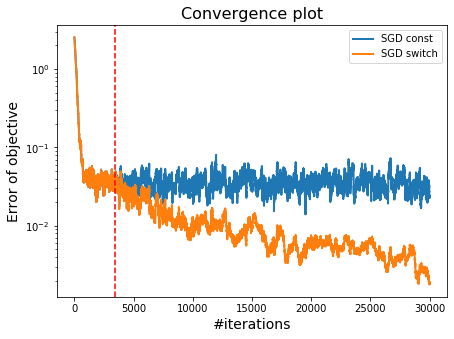

None


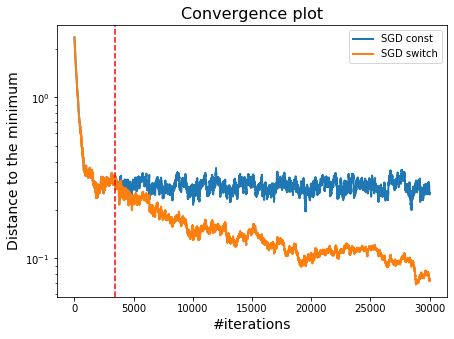

None


In [205]:
# Plotting to compare with constant stepsize 
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switch", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()
plt.axvline(x=tstar, color = "red", linestyle='dashed')
#plt.savefig('images/sgd_switch_err.png', bbox_inches='tight')
print(plt.show())

# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr, label="SGD const", lw=2)
plt.semilogy(err_sgdss , label="SGD switch", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

plt.axvline(x=tstar,  color = "red", linestyle='dashed')
#plt.savefig('images/sgd_switch_dist.png', bbox_inches='tight')
print(plt.show())

## 5. Compare with averaging step

- Implement the average iterate output  
- Compare the solution you obtain for SGD with shrinking stepsizes and SGD with averaging. 
- What happens if you start averaging only the last n iterates? When is averaging useful?


In [206]:
#############TODO#######################
# Execute SGD with averaging on and shrinking stepsize. Please name the output as
# w_sgdar, obj_sgdar, err_sgdar = sgd( .... )
# HINT: you can use the same stepsizes as decreasing and average just the last n_iter/4 steps
###############END TODO#####################

steps = np.ones(n_iter)*(1/(2*Lmax))
start_late_averaging = (n_iter/4)
w_sgdar, obj_sgdar, err_sgdar = sgd(w0,model,indices,steps,w_min,n_iter,averaging_on=True,start_averaging=(n_iter/4))

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 3.03e+00 | 2.36e+00
    1000 | 5.38e-01 | 3.54e-01
    2000 | 5.26e-01 | 2.52e-01
    3000 | 5.30e-01 | 3.00e-01
    4000 | 5.30e-01 | 2.75e-01
    5000 | 5.24e-01 | 2.70e-01
    6000 | 5.29e-01 | 2.95e-01
    7000 | 5.35e-01 | 2.97e-01
    8000 | 5.08e-01 | 2.02e-01
    9000 | 5.02e-01 | 1.61e-01
   10000 | 4.99e-01 | 1.30e-01
   11000 | 4.98e-01 | 1.12e-01
   12000 | 4.98e-01 | 1.10e-01
   13000 | 4.98e-01 | 1.01e-01
   14000 | 4.97e-01 | 9.15e-02
   15000 | 4.97e-01 | 8.79e-02
   16000 | 4.97e-01 | 8.71e-02
   17000 | 4.97e-01 | 8.51e-02
   18000 | 4.96e-01 | 8.13e-02
   19000 | 4.96e-01 | 7.64e-02
   20000 | 4.96e-01 | 7.13e-02
   21000 | 4.96e-01 | 6.88e-02
   22000 | 4.96e-01 | 6.72e-02
   23000 | 4.96e-01 | 6.53e-02
   24000 | 4.96e-01 | 6.62e-02
   25000 | 4.96e-01 | 6.77e-02
   26000 | 4.96e-01 | 6.75e-02
   27000 | 4.96e-01 | 6.58e-02
   28000 | 4.96e-01 | 6.48e-02
   29000 | 4.96e-01 | 6.32e-02


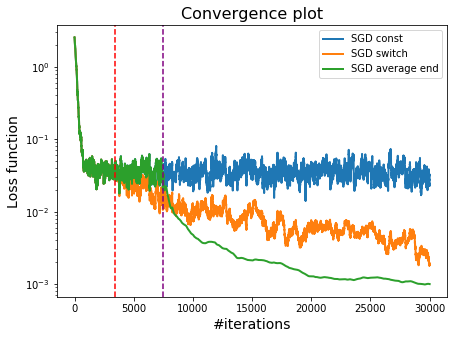

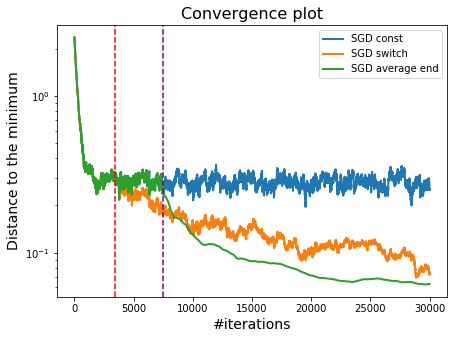

In [207]:
# Plotting to compare constant stepsize, switchting, switching + averaging
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switch", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD average end", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
plt.axvline(x=tstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging, color = "purple", linestyle='dashed')
#plt.savefig('images/sgd_switch_average_err.png', bbox_inches='tight')

# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdcr, label="SGD const", lw=2)
plt.semilogy(err_sgdss , label="SGD switch", lw=2)
plt.semilogy(err_sgdar , label="SGD average end", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
plt.axvline(x=tstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging, color = "purple", linestyle='dashed')
#plt.savefig('images/sgd_switch_average_dist.png', bbox_inches='tight')

## Compare with SGD with momentum (SGDm)

- Implement the momentum variant in SGD
- Compare with averaging and decreasing stepsizes with late start
- For what momentum parameters does SGDm work well?
- Combining all the tricks/variants seen so far, what is the best variant of SGD for this problem?

In [208]:
##############TODO######################
# Execute SGD with a constant stepsize. Please name the output as
# w_sgdcr, obj_sgdcr, err_sgdcr = sgd(...?....)
# averaging_on = False
# momentum = ??
# w_sgdm, obj_sgdm, err_sgdm = sgd(w0,model, indices, steps_switch, w_min, n_iter, averaging_on, momentum, True, start_late_averaging)
##############END TODO######################
momentum = (np.sqrt(Lmax)-np.sqrt(mu))/(np.sqrt(Lmax)+np.sqrt(mu))
averaging_on = True
steps = []
for i in range(n_iter):
  if i <= tstar:
    steps.append(1/(2*Lmax))
  else:
    steps.append((2*(i+1))/(((i+1)**2)*mu))
w_sgdm, obj_sgdm, err_sgdm = sgd(w0,model, indices, steps, w_min, n_iter, averaging_on, momentum, True, start_late_averaging)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 3.03e+00 | 2.36e+00
    1000 | 5.38e-01 | 3.54e-01
    2000 | 5.26e-01 | 2.52e-01
    3000 | 5.30e-01 | 3.00e-01
    4000 | 5.26e-01 | 2.59e-01
    5000 | 5.13e-01 | 2.16e-01
    6000 | 5.17e-01 | 2.37e-01
    7000 | 5.16e-01 | 2.13e-01
    8000 | 5.04e-01 | 1.61e-01
    9000 | 5.00e-01 | 1.34e-01
   10000 | 4.98e-01 | 1.15e-01
   11000 | 4.98e-01 | 9.92e-02
   12000 | 4.97e-01 | 9.50e-02
   13000 | 4.97e-01 | 8.75e-02
   14000 | 4.97e-01 | 7.92e-02
   15000 | 4.96e-01 | 7.36e-02
   16000 | 4.96e-01 | 7.06e-02
   17000 | 4.96e-01 | 6.77e-02
   18000 | 4.96e-01 | 6.53e-02
   19000 | 4.96e-01 | 6.21e-02
   20000 | 4.96e-01 | 5.88e-02
   21000 | 4.96e-01 | 5.61e-02
   22000 | 4.96e-01 | 5.38e-02
   23000 | 4.95e-01 | 5.17e-02
   24000 | 4.95e-01 | 5.09e-02
   25000 | 4.95e-01 | 5.09e-02
   26000 | 4.95e-01 | 5.08e-02
   27000 | 4.95e-01 | 5.00e-02
   28000 | 4.95e-01 | 4.87e-02
   29000 | 4.95e-01 | 4.75e-02


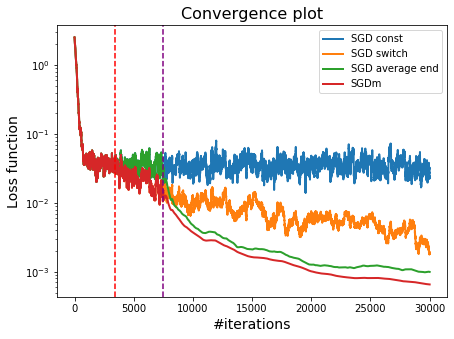

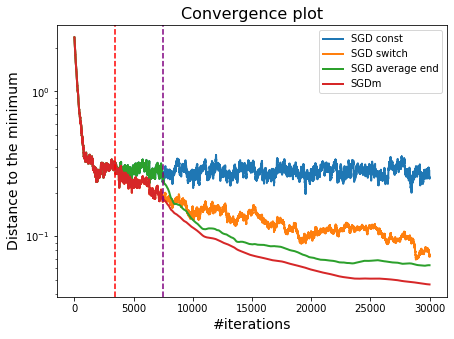

In [209]:
# Plotting to compare constant stepsize, switchting, switching + averaging
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switch", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD average end", lw=2)
plt.semilogy(obj_sgdm - obj_min, label="SGDm", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
plt.axvline(x=tstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging, color = "purple", linestyle='dashed')
#plt.savefig('images/sgd_switch_average_err.png', bbox_inches='tight')
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdcr, label="SGD const", lw=2)
plt.semilogy(err_sgdss , label="SGD switch", lw=2)
plt.semilogy(err_sgdar , label="SGD average end", lw=2)
plt.semilogy(err_sgdm , label="SGDm", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
plt.axvline(x=tstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging, color = "purple", linestyle='dashed')
#plt.savefig('images/sgd_switch_average_dist.png', bbox_inches='tight')

## Compare with gradient descent

- Complete the code of gradient descent (GD) below
- How much more is the computational cost of a step of gradient descent with respect to the computational cost of a SGD step?  How many steps of gradient descent should you take so that the total computational complexity is equivalent to datapasses * n steps of SGD ? 
- Compare GD with SGD, where on the $x$-axis of the plot you the total computational effort spent
- What happens if you increase the number of datapasses?

In [0]:
def gd(w0, model, step, w_min =[], n_iter=100, verbose=True):
    """Gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # estimation error history
    errors = []
    err = 1.
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w) 
    objectives.append(obj)
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter ):
        ##### TODO ######################
        ##### Compute gradient step update
        #####   w[:] = ...
        ##### END TODO ##################
        w = w - step*model.grad(w)
        obj = model.f(w) 
        if (sum(w_min)):
            err = norm(w - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return w, np.array(objectives), np.array(errors)

In [211]:
step = 1. / model.lipschitz_constant()
w_gd, obj_gd, err_gd = gd(w0, model, step, w_min, datapasses)
print(obj_gd)

Lauching GD solver...
   it    |   obj    |   err   
       0 | 2.29e+00 | 1.92e+00
       1 | 1.66e+00 | 1.52e+00
       2 | 1.15e+00 | 1.18e+00
       3 | 7.98e-01 | 9.18e-01
       4 | 6.33e-01 | 7.49e-01
       5 | 5.79e-01 | 6.43e-01
       6 | 5.56e-01 | 5.64e-01
       7 | 5.40e-01 | 4.97e-01
       8 | 5.30e-01 | 4.41e-01
       9 | 5.22e-01 | 3.92e-01
      10 | 5.16e-01 | 3.49e-01
      11 | 5.11e-01 | 3.12e-01
      12 | 5.08e-01 | 2.80e-01
      13 | 5.05e-01 | 2.51e-01
      14 | 5.03e-01 | 2.25e-01
      15 | 5.01e-01 | 2.03e-01
      16 | 5.00e-01 | 1.83e-01
      17 | 4.99e-01 | 1.65e-01
      18 | 4.98e-01 | 1.49e-01
      19 | 4.97e-01 | 1.35e-01
      20 | 4.97e-01 | 1.22e-01
      21 | 4.97e-01 | 1.11e-01
      22 | 4.96e-01 | 1.00e-01
      23 | 4.96e-01 | 9.11e-02
      24 | 4.96e-01 | 8.27e-02
      25 | 4.95e-01 | 7.51e-02
      26 | 4.95e-01 | 6.82e-02
      27 | 4.95e-01 | 6.20e-02
      28 | 4.95e-01 | 5.64e-02
      29 | 4.95e-01 | 5.13e-02
[3.02741806 2.294

In [212]:
complexityofGD = n * np.arange(0, datapasses + 1)
print(complexityofGD)

[    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000
 24000 25000 26000 27000 28000 29000 30000]


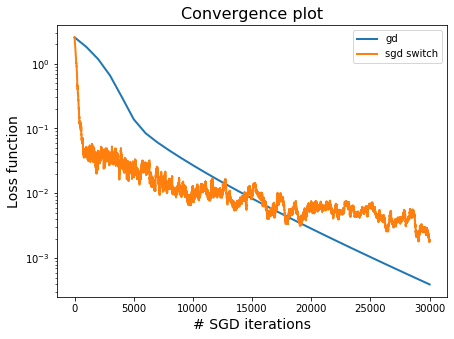

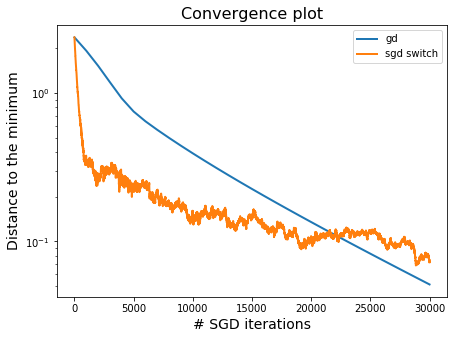

In [213]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(complexityofGD, obj_gd - obj_min, label="gd", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="sgd switch", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("# SGD iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)

plt.legend()
# Distance to the minimum on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(complexityofGD, err_gd, label="gd", lw=2)
plt.semilogy(err_sgdss , label="sgd switch", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("# SGD iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## BONUS: SGD without replacement

-Execute SGD where the indices of the data points are sampled *without* replacement over each datapass

In [226]:
#############TODO#######################
# Execute SGD with averaging on and shrinking stepsize. Please name the output as
# w_sgdsw, obj_sgdsw, err_sgdsw = sgd(....)
# HINT: You should use numpy.matlib's repmat function to  
import numpy.matlib
# With replacement
#indices = np.matlib.repmat(... )
###############END TODO#####################
indices = np.tile(np.random.choice(model.n,size=model.n,replace=False),datapasses)
C = 2 / Lmax
steps = C / np.sqrt(np.array(range(n_iter))+1)
w_sgdsw, obj_sgdsw, err_sgdsw = sgd(w0,model, indices, steps, w_min, n_iter)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 3.02e+00 | 2.36e+00
    1000 | 9.45e-01 | 1.04e+00
    2000 | 6.45e-01 | 7.56e-01
    3000 | 5.79e-01 | 6.29e-01
    4000 | 5.54e-01 | 5.48e-01
    5000 | 5.40e-01 | 4.89e-01
    6000 | 5.31e-01 | 4.42e-01
    7000 | 5.24e-01 | 4.04e-01
    8000 | 5.20e-01 | 3.72e-01
    9000 | 5.16e-01 | 3.45e-01
   10000 | 5.13e-01 | 3.21e-01
   11000 | 5.10e-01 | 3.00e-01
   12000 | 5.08e-01 | 2.82e-01
   13000 | 5.07e-01 | 2.65e-01
   14000 | 5.05e-01 | 2.50e-01
   15000 | 5.04e-01 | 2.37e-01
   16000 | 5.03e-01 | 2.25e-01
   17000 | 5.02e-01 | 2.14e-01
   18000 | 5.02e-01 | 2.04e-01
   19000 | 5.01e-01 | 1.94e-01
   20000 | 5.00e-01 | 1.85e-01
   21000 | 5.00e-01 | 1.77e-01
   22000 | 4.99e-01 | 1.70e-01
   23000 | 4.99e-01 | 1.63e-01
   24000 | 4.99e-01 | 1.56e-01
   25000 | 4.98e-01 | 1.50e-01
   26000 | 4.98e-01 | 1.44e-01
   27000 | 4.98e-01 | 1.39e-01
   28000 | 4.98e-01 | 1.34e-01
   29000 | 4.97e-01 | 1.29e-01


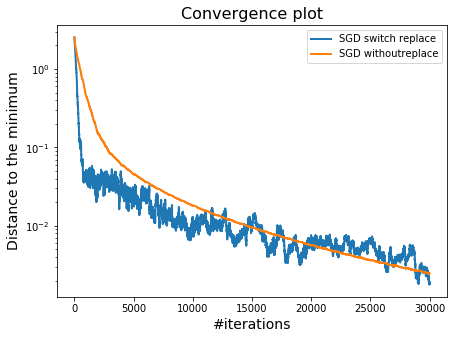

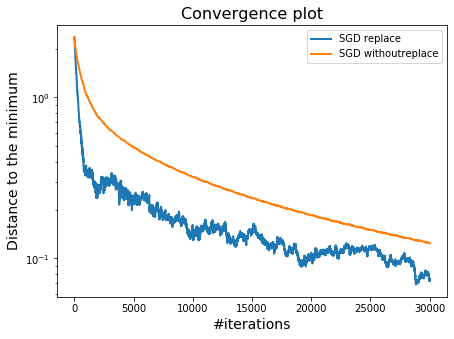

In [227]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(obj_sgdss - obj_min, label="SGD switch replace", lw=2)
plt.plot(obj_sgdsw - obj_min, label="SGD withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(err_sgdss , label="SGD replace", lw=2)
plt.plot(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

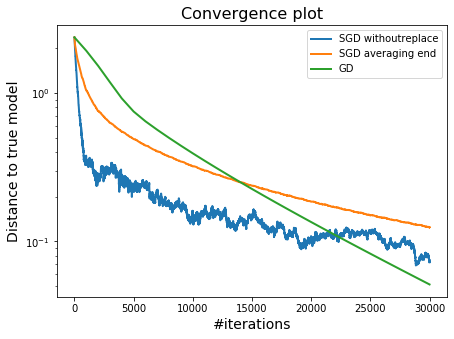

In [228]:
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdss , label="SGD withoutreplace", lw=2)
plt.semilogy(err_sgdsw , label="SGD averaging end", lw=2)
plt.semilogy(complexityofGD, err_gd , label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to true model", fontsize=14)
plt.legend()

## Compare SGD and GD in terms of test error. That is, use w_model_truth to compare¶

In [0]:
datapasses = 30;
n_iters = int(datapasses * n)


## SGD without replacement, decreasing stepsize, averaging at end
#############TODO#######################
# w_sgdar, obj_sgdar, err_sgdar    = sgd(... w_model_truth ...) 
###############END TODO#####################



## SGD without replacement, decreasing stepsize, no averaging
#############TODO#######################
#  w_sgdsw, obj_sgdsw, err_sgdsw = sgd( ...  w_model_truth ...);
###############END TODO#####################

## GD
#############TODO#######################
# w_gd, obj_gd, err_gd = gd( ...  w_model_truth ... )
###############END TODO#####################

In [0]:
complexityofGD = n * np.arange(0, datapasses + 1)

# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.semilogy(err_sgdar , label="SGD averaging end", lw=2)
plt.semilogy(complexityofGD, err_gd , label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to true model", fontsize=14)
plt.legend()

## THE END!